# Neural Networks and Linear Regression

In [1]:
%matplotlib inline

from itertools import combinations

import pandas as pd
from datetime import datetime
import numpy as np
import os

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, mean_absolute_error
from sklearn import metrics
from sklearn.linear_model import LinearRegression

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchviz import make_dot

import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
## Custom plotly plot styling

# Remove the red color in discrete color scale
px.colors.qualitative.Plotly = px.colors.qualitative.Plotly[:1] + px.colors.qualitative.Plotly[2:]

pio.templates["custom"] = go.layout.Template(
    layout=go.Layout(
        paper_bgcolor="rgba(0, 0, 0, 0)",
        font=dict(color="lightgreen"),
        colorscale=dict(sequential="Viridis"),
        colorway=px.colors.qualitative.Plotly)
)

pio.templates.default = "plotly+custom"

# Settings for plot rendering, makes work with HTML output + jupyer lab + static output
pio.renderers.default = "plotly_mimetype+notebook_connected+png"

## Load Data

In [3]:
data_path = os.path.normpath("../data/products_cleaned.csv")
df_az = pd.read_csv(data_path, dtype={"Category": "category"}, parse_dates=["Date Scraped"])

print(df_az.dtypes)
df_az

Asin                       object
Name                       object
Image Url                  object
Is Best Seller               bool
Stars                     float64
Reviews                   float64
Url                        object
Price                     float64
Date Scraped       datetime64[ns]
List Price                float64
Bought In Month           float64
Category                 category
dtype: object


,Asin,Name,Image Url,Is Best Seller,Stars,Reviews,Url,Price,Date Scraped,List Price,Bought In Month,Category
0,B0CSPPHXXV,Apple Watch Ultra 2 (GPS + Cellular 49mm) Rugg...,https://m.media-amazon.com/images/I/814xH1gpid...,False,NaN,0.0,https://www.amazon.com/Apple-Cellular-Rugged-T...,699.97,2024-02-01,779.99,NaN,NaN
1,B0BDJ4MGFQ,AppleWatch Series 8 [GPS + Cellular 45mm] Smar...,https://m.media-amazon.com/images/I/91WpS8h5Jv...,False,4.7,4100.0,https://www.amazon.com/Apple-Cellular-Starligh...,689.00,2024-02-01,799.00,NaN,NaN
2,B0CSV7LK7D,AppleWatch Series 9 [GPS + Cellular 45mm] Smar...,https://m.media-amazon.com/images/I/61DZ+Vezk0...,False,NaN,0.0,https://www.amazon.com/Apple-Cellular-Smartwat...,679.00,2024-02-01,679.00,NaN,NaN
3,B0B8GHHD2F,AppleWatch Series 7 [GPS + Cellular 45mm] Smar...,https://m.media-amazon.com/images/I/51aQmgx9Ql...,False,NaN,0.0,https://www.amazon.com/Apple-Cellular-Aluminum...,608.00,2024-02-01,608.00,NaN,NaN
4,B0B8GDV9GN,AppleWatch Series 7 [GPS + Cellular 45mm] Smar...,https://m.media-amazon.com/images/I/61O671oWHg...,False,NaN,0.0,https://www.amazon.com/Apple-Cellular-Aluminum...,608.00,2024-02-01,608.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1389694,B00R3LIKCO,American Flag Patriotic USA Classic 5 Panel Me...,https://m.media-amazon.com/images/I/71PDJFz6AA...,False,4.2,0.0,https://www.amazon.com/dp/B00R3LIKCO,14.95,2023-11-01,14.95,0.0,Men's Accessories
1389695,B098BQ7ZQ3,Men's Baseball Cap - H2O-DRI Line Up Curved Br...,https://m.media-amazon.com/images/I/812Tycexs4...,False,4.4,0.0,https://www.amazon.com/dp/B098BQ7ZQ3,33.99,2023-11-01,33.99,0.0,Men's Accessories
1389696,B07X1MVNT1,[4 Pack] Adjustable Eyeglasses and Sunglasses ...,https://m.media-amazon.com/images/I/61vvYW1S9J...,False,3.6,0.0,https://www.amazon.com/dp/B07X1MVNT1,8.54,2023-11-01,8.54,0.0,Men's Accessories
1389697,B08XLBG8V9,Ax2002 Aviator Sunglasses,https://m.media-amazon.com/images/I/51+yjD4F1x...,False,4.5,0.0,https://www.amazon.com/dp/B08XLBG8V9,54.36,2023-11-01,57.39,0.0,Men's Accessories


## Data Prep

### Best Seller Data

In [4]:
feat_cols = ["Stars", "Reviews", "Price", "Date Scraped", "Bought In Month", "Is Best Seller"]

# Usa data such that: has Category, has Bought in Month
df_nn_bs = df_az[~df_az["Category"].isna() & ~df_az["Bought In Month"].isna()][feat_cols]

# Use 1% == Best Seller
num_bs = len(df_nn_bs[df_nn_bs["Is Best Seller"] == True])
df_nn_bs = pd.concat([df_nn_bs[df_nn_bs["Is Best Seller"] == True], df_nn_bs[df_nn_bs["Is Best Seller"] != True].sample(num_bs * 100, random_state=42)])

# Make datetime binary
df_nn_bs["Date Scraped"] = df_nn_bs["Date Scraped"].map({datetime(2023, 11, 1): 0, datetime(2024, 2, 1): 1})

df_nn_bs["Is Best Seller"] = df_nn_bs["Is Best Seller"].astype(int)

# One-hot encode categorical var `Category`
df_nn_bs = pd.concat([df_nn_bs, pd.get_dummies(df_az[~df_az["Category"].isna() & ~df_az["Bought In Month"].isna()]["Category"], dtype=int)], axis="columns").fillna(0)

print(df_nn_bs.sample(10).iloc[:, :6].to_markdown(index=False))

df_nn_bs

|   Stars |   Reviews |   Price |   Date Scraped |   Bought In Month |   Is Best Seller |
|--------:|----------:|--------:|---------------:|------------------:|-----------------:|
|     4.5 |         0 |   21.99 |              0 |                 0 |                0 |
|     4.1 |         0 |   33.99 |              0 |               100 |                0 |
|     0   |         0 |    0    |              0 |                 0 |                0 |
|     4.3 |         0 |   82.99 |              0 |                50 |                0 |
|     0   |         0 |    0    |              0 |                 0 |                0 |
|     0   |         0 |    0    |              0 |                 0 |                0 |
|     0   |         0 |    0    |              0 |                 0 |                0 |
|     4.5 |         0 |   78    |              0 |                 0 |                0 |
|     4.3 |         0 |   16.99 |              0 |                 0 |                0 |
|     0   

,Stars,Reviews,Price,Date Scraped,Bought In Month,Is Best Seller,Men's Accessories,Men's Clothing,Men's Shoes,Suitcases,...,Tablet Accessories,Automotive Interior Accessories,Food Service Equipment & Supplies,"Paint, Wall Treatments & Supplies",Rain Umbrellas,"Test, Measure & Inspect",Travel Accessories,Travel Tote Bags,Car Electronics & Accessories,Stationery & Gift Wrapping Supplies
14980,4.3,0.0,84.85,0.0,700.0,1.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14994,4.6,0.0,29.99,0.0,1000.0,1.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
15002,4.7,0.0,24.99,0.0,1000.0,1.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
15005,4.7,0.0,12.95,0.0,3000.0,1.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
15006,4.6,0.0,19.98,0.0,3000.0,1.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389693,0.0,0.0,0.00,0.0,0.0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1389694,0.0,0.0,0.00,0.0,0.0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1389695,0.0,0.0,0.00,0.0,0.0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1389697,0.0,0.0,0.00,0.0,0.0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Price Increase Data

In [5]:
# Make DF of products that have a calculable price difference over time
df_same = df_az[df_az["Asin"].duplicated(keep=False)].sort_values(["Asin", "Date Scraped"]).reset_index()
diffs = df_same[["Asin", "Date Scraped", "Price", "List Price"]].set_index("Asin").groupby(level=0).diff().reset_index()
df_same["Price Diff"] = diffs["Price"]
df_same["List Price Diff"] = diffs["List Price"]
df_same["Price Diff"] = df_same["Price Diff"].bfill(limit=1)
df_same["Increased"] = df_same["Price Diff"] > 0
df_same["Bought In Month"] = df_same["Bought In Month"].ffill(limit=1)
df_same["Category"] = df_same["Category"].ffill().cat.remove_unused_categories()

# Use initial price and data, in order to predict later price change
df_diff = df_same[df_same["Date Scraped"] > pd.Timestamp("2023-11-01")]

# Scale numerical data to [0, 1], make bool `Is Best Seller` an int
df_nn_inc = df_diff[["Is Best Seller", "Stars", "Reviews", "Price", "List Price", "Bought In Month", "Price Diff"]]
df_nn_inc["Is Best Seller"] = df_nn_inc["Is Best Seller"].astype(int)

# One-hot encode categorical var `Category`
df_nn_inc = pd.concat([df_nn_inc, pd.get_dummies(df_diff["Category"], dtype=int)], axis="columns").fillna(0)

print(df_nn_inc.sample(10).iloc[:, :7].to_markdown(index=False))

df_nn_inc

|   Is Best Seller |   Stars |   Reviews |   Price |   List Price |   Bought In Month |   Price Diff |
|-----------------:|--------:|----------:|--------:|-------------:|------------------:|-------------:|
|                0 |     4.8 |       352 |   41    |        55    |               200 |        -4.95 |
|                0 |     4.8 |       610 |   22.98 |        22.98 |                 0 |         0    |
|                0 |     4.3 |      2159 |    7.99 |        19.99 |               100 |       -12    |
|                0 |     4.2 |        17 |    9.99 |         9.99 |                 0 |         0    |
|                0 |     4.2 |      2006 |    5.99 |         5.99 |              1000 |         0    |
|                0 |     4.7 |      3924 |   54.22 |        73.29 |               200 |       -18.07 |
|                0 |     4.5 |      1553 |   19.51 |        19.51 |              1000 |        -0.48 |
|                0 |     4.4 |      5238 |  227    |       529    |      

C:\Users\Bhavana\AppData\Local\Temp\ipykernel_25416\3639429484.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Is Best Seller,Stars,Reviews,Price,List Price,Bought In Month,Price Diff,Men's Clothing,Men's Shoes,Suitcases,...,"Nintendo 3DS & 2DS Consoles, Games & Accessories",Personal Care Products,Automotive Replacement Parts,Backpacks,Craft Supplies & Materials,Laptop Bags,Automotive Interior Accessories,Food Service Equipment & Supplies,Travel Accessories,Travel Tote Bags
1,0,4.7,845.0,3.25,3.25,200.0,-0.02,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,4.7,64.0,44.95,44.95,0.0,4.51,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,4.6,1126.0,110.00,150.00,200.0,-32.00,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7,0,4.7,2914.0,78.56,78.56,300.0,2.60,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,3.8,2582.0,34.25,72.99,800.0,-5.74,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3323,0,4.7,91.0,23.99,23.99,0.0,-3.00,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3325,0,3.3,8.0,3.99,4.99,0.0,-6.00,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3327,0,3.9,267.0,409.00,449.99,0.0,-40.99,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3329,0,4.8,2624.0,21.99,79.99,0.0,-78.00,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
class NNDataset(Dataset):
    def __init__(self, df, y_col):
        self.x = torch.Tensor(df.drop(columns=y_col).to_numpy())
        self.y = torch.Tensor(df[y_col].to_numpy())

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_bs, test_bs = train_test_split(df_nn_bs, random_state=42, stratify=df_nn_bs["Is Best Seller"])
train_pd, test_pd = train_test_split(df_nn_inc, random_state=42, stratify=df_nn_inc["Price Diff"] > 0)

train_bs, test_bs = NNDataset(train_bs, "Is Best Seller"), NNDataset(test_bs, "Is Best Seller")
train_bs.y = train_bs.y.type(torch.LongTensor)
test_bs.y = test_bs.y.type(torch.LongTensor)
train_pd, test_pd = NNDataset(train_pd, "Price Diff"), NNDataset(test_pd, "Price Diff")

batch_size = 100
train_bs_dl, test_bs_dl = DataLoader(train_bs, shuffle=True, batch_size=batch_size), DataLoader(test_bs, shuffle=True, batch_size=batch_size)
train_pd_dl, test_pd_dl = DataLoader(train_pd, shuffle=True), DataLoader(test_pd, shuffle=True)

### Regression Data

In [8]:
df_lr = df_az[["Reviews", "Stars"]]
df_lr = df_lr.fillna(0)

print(df_lr.sample(10).to_markdown(index=False))

|   Reviews |   Stars |
|----------:|--------:|
|       835 |     4.8 |
|         0 |     4.7 |
|         0 |     4.5 |
|       195 |     4.6 |
|         9 |     4.7 |
|         0 |     5   |
|         0 |     3.8 |
|         0 |     3.6 |
|         0 |     0   |
|         0 |     4.7 |


## Linear Regression

### Model Selection

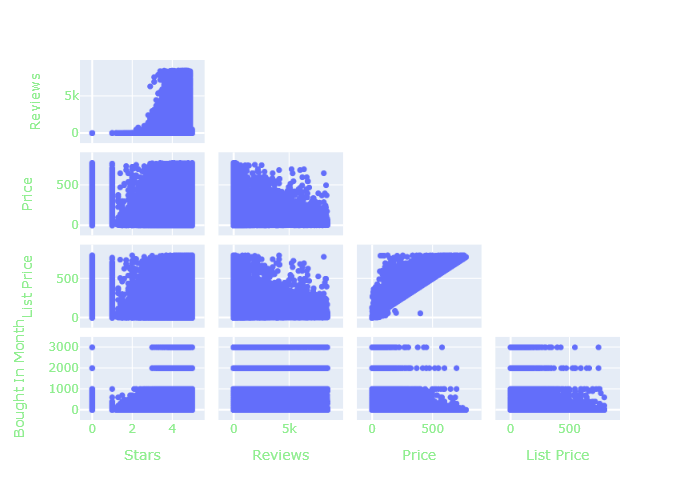

In [9]:
fig = px.scatter_matrix(df_az.select_dtypes("number"))
fig.update_traces(diagonal_visible=False, showupperhalf=False)
fig.show(renderer="png")

### Running and Results

In [10]:
lr_X = df_lr["Reviews"].to_numpy().reshape(-1, 1)

lr = LinearRegression()
lr.fit(lr_X, df_lr["Stars"])

reg_metrics = [metrics.mean_squared_error, metrics.mean_absolute_error, metrics.explained_variance_score, metrics.r2_score]
print(pd.DataFrame([{"Metric": m.__name__, "Value": m(df_lr["Stars"], lr.predict(lr_X))} for m in reg_metrics]).to_markdown(index=False))
print(lr.__dict__)

| Metric                   |      Value |
|:-------------------------|-----------:|
| mean_squared_error       | 1.819      |
| mean_absolute_error      | 0.849941   |
| explained_variance_score | 0.00510836 |
| r2_score                 | 0.00510836 |
{'fit_intercept': True, 'copy_X': True, 'n_jobs': None, 'positive': False, 'n_features_in_': 1, 'coef_': array([0.00016959]), 'rank_': 1, 'singular_': array([671798.84505618]), 'intercept_': 3.974664649695972}


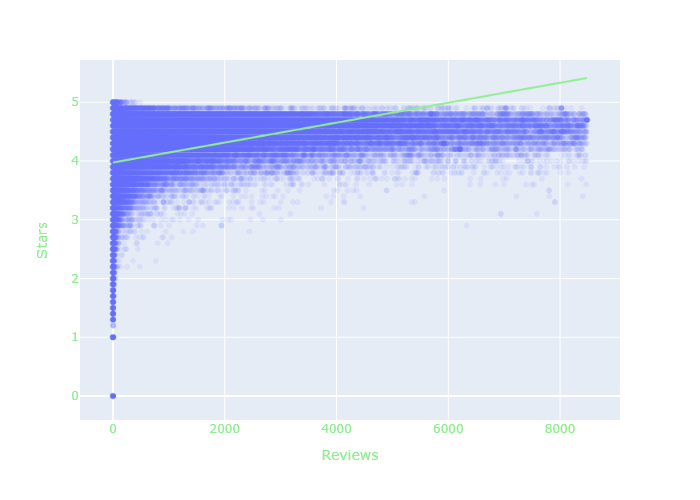

In [11]:
lr_X_sorted = df_lr["Reviews"].sort_values()
lr_y_pred = lr.predict(lr_X_sorted.to_numpy().reshape(-1, 1))

fig = px.scatter(df_lr, x="Reviews", y="Stars", opacity=0.1, trendline="ols", trendline_color_override="lightgreen")
# fig.add_trace(go.Scatter(x=lr_X_sorted, y=lr_y_pred, name="Regression Line"))
# fig.data = fig.data[::-1]
fig.show(renderer="png")

-----
## Neural Networks

### Model Definition

In [32]:
class BaseNNAz(nn.Module):
    def __init__(self, in_dim, out_dim=1, activation_fn = nn.Sigmoid, out_fn = nn.Identity):
      super(BaseNNAz, self).__init__()
      # self.layers = nn.Sequential(
      #     nn.Linear(in_dim, round(in_dim * 1.3)),
      #     activation_fn(),
      #     nn.Linear(round(in_dim * 1.3), round(in_dim * 0.75)),
      #     activation_fn(),
      #     nn.Linear(round(in_dim * 0.75), round(in_dim * 0.25)),
      #     activation_fn(),
      #     nn.Linear(round(in_dim * 0.25), out_dim),
      #     out_fn()
      # )

      self.layers = nn.Sequential(
          nn.Linear(in_dim, round(in_dim * 0.75)),
          activation_fn(),
          nn.Linear(round(in_dim * 0.75), round(in_dim * 0.50)),
          activation_fn(),
          nn.Linear(round(in_dim * 0.50), round(in_dim * 0.25)),
          activation_fn(),
          nn.Linear(round(in_dim * 0.25), out_dim),
          out_fn()
      )

    # x represents our data
    def forward(self, x):
        x = self.layers(x)
        return x

nn_bs = BaseNNAz(train_bs.x.shape[1], out_dim=2, activation_fn=nn.Tanh, out_fn=nn.ReLU)
nn_pd = BaseNNAz(train_pd.x.shape[1], activation_fn=nn.Tanh)

### Training

In [29]:
loss_fn_default = nn.MSELoss()
opt = torch.optim.Adam

def train(model, optimizer, train_dl, test_dl, epochs=50, loss_fn=loss_fn_default):
    train_loss = []
    val_loss = []

    for e in range(epochs):
        # Make sure gradient tracking is on
        model.train(True)
        
        running_loss = 0.
        running_vloss = 0.
        for inputs, target in iter(train_dl):
            # Zero your gradients for every batch!
            optimizer.zero_grad()
            # Make predictions for this batch
            outputs = model(inputs)
            # Compute the loss and its gradients
            loss = loss_fn(outputs, target)
            loss.backward()
            # Adjust learning weights
            optimizer.step()
            # Gather data
            running_loss += loss.item()

        train_loss.append(running_loss / len(train_dl))
        
        # Set the model to evaluation mode
        model.eval()
        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for vinputs, vtarget in iter(test_dl):
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vtarget)
                running_vloss += vloss.item()
        val_loss.append(running_vloss / len(test_dl))

        print(f"Epoch {e} Loss: {train_loss[-1]}\t Validation Loss: {val_loss[-1]}")

    return dict(train_loss=train_loss, validation_loss=val_loss)

In [14]:
# sum(train_bs.y) / len(train_bs.y)
(1 - sum(test_bs.y) / len(test_bs.y)).item()

0.9951469302177429

In [33]:
true_frac = (sum(test_bs.y) / len(test_bs.y)).item()
losses_bs = train(nn_bs, 
                  opt(nn_bs.parameters()), 
                  train_bs_dl, 
                  test_bs_dl, 
                  loss_fn=nn.CrossEntropyLoss(weight=torch.tensor([true_frac, 1 - true_frac])),
                 )

Epoch 0 Loss: 0.38879261160333284	 Validation Loss: 0.39886645258425973
Epoch 1 Loss: 0.364324007173204	 Validation Loss: 0.3744275824188493
Epoch 2 Loss: 0.3500039911482149	 Validation Loss: 0.32530237312406995
Epoch 3 Loss: 0.34753416464805753	 Validation Loss: 0.326109366279182
Epoch 4 Loss: 0.35019416635288103	 Validation Loss: 0.3673268444446284
Epoch 5 Loss: 0.35382510408582923	 Validation Loss: 0.34306612720409796
Epoch 6 Loss: 0.34957441716142795	 Validation Loss: 0.36916596139672886
Epoch 7 Loss: 0.35530274081307284	 Validation Loss: 0.3499603644121698
Epoch 8 Loss: 0.35342127921062977	 Validation Loss: 0.3559262676922561
Epoch 9 Loss: 0.3480565032995205	 Validation Loss: 0.35283794010404584
Epoch 10 Loss: 0.3480494789288883	 Validation Loss: 0.35796818759638904
Epoch 11 Loss: 0.34298011163413167	 Validation Loss: 0.3228163083192221
Epoch 12 Loss: 0.31917398722192813	 Validation Loss: 0.3125658557468722
Epoch 13 Loss: 0.31318806488854717	 Validation Loss: 0.2971237156496838
Ep

KeyboardInterrupt: 

In [34]:
losses_pd = train(nn_pd, opt(nn_pd.parameters()), train_pd_dl, test_pd_dl, epochs=200)

C:\Users\Bhavana\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning:

Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch 0 Loss: 244.10836683303157	 Validation Loss: 222.88767863666908
Epoch 1 Loss: 243.1841998127264	 Validation Loss: 222.40651604805166
Epoch 2 Loss: 241.77292977513994	 Validation Loss: 226.0520708838269
Epoch 3 Loss: 242.35023307576392	 Validation Loss: 225.43382826823242
Epoch 4 Loss: 239.17581120668632	 Validation Loss: 228.4970351140338
Epoch 5 Loss: 242.42739528027553	 Validation Loss: 223.63090916628806
Epoch 6 Loss: 242.62004690904683	 Validation Loss: 221.5772611500798
Epoch 7 Loss: 241.82975793299298	 Validation Loss: 224.55229485433816
Epoch 8 Loss: 239.40032910826125	 Validation Loss: 226.15997711798175
Epoch 9 Loss: 241.03176703105854	 Validation Loss: 222.41026267801243
Epoch 10 Loss: 239.24629291431316	 Validation Loss: 221.87520763321783
Epoch 11 Loss: 239.46223620840883	 Validation Loss: 222.94777395875323
Epoch 12 Loss: 239.21041998465256	 Validation Loss: 218.71741958154809
Epoch 13 Loss: 239.50181958481423	 Validation Loss: 218.90272476363228
Epoch 14 Loss: 241.8

### Results

In [35]:
df_losses = [pd.DataFrame(losses_bs), pd.DataFrame(losses_pd)]
for i in range(2):
    df_losses[i] = df_losses[i].reset_index().rename(columns={"index": "Epoch"})
    df_losses[i]["validation_loss"] = df_losses[i]["validation_loss"].apply(lambda x: x.item()) if i==0 else df_losses[i]["validation_loss"]
    df_losses[i].columns = df_losses[i].columns.str.replace("_", " ")
    df_losses[i] = df_losses[i].melt(id_vars="Epoch", var_name="Type", value_name="Loss")
    
    fig = px.scatter(df_losses[i], x="Epoch", y="Loss", color="Type", 
                     # trendline="rolling", trendline_options={"window": 20}
                    )
    fig.update_traces(mode = 'lines')
    fig.update_layout(title=["Cross-Entropy Loss During Training", "MSE Loss During Training"][i])
    fig.show()


NameError: name 'losses_bs' is not defined

In [36]:
nn_bs.eval()
nn_pd.eval()
y_pred_bs = nn_bs(test_bs.x).detach().numpy()
y_pred_bs = np.argmax(y_pred_bs, axis=1)
y_pred_pd = nn_pd(test_pd.x).detach().numpy()

0.9176519165120701


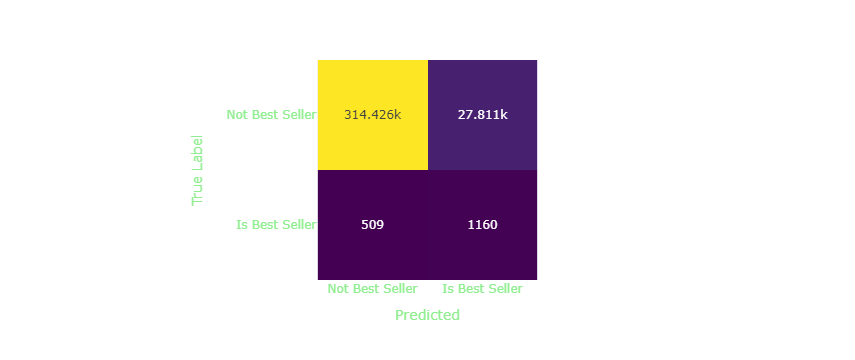

7.128182 14.939116


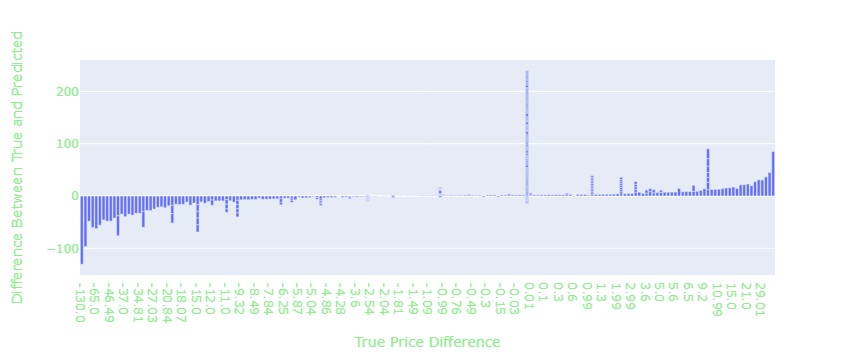

|                 |   precision |   recall |   f1-score |       support |
|:----------------|------------:|---------:|-----------:|--------------:|
| Not Best Seller |    0.998384 | 0.918738 |   0.956906 | 342237        |
| Is Best Seller  |    0.04004  | 0.695027 |   0.075718 |   1669        |
| accuracy        |    0.917652 | 0.917652 |   0.917652 |      0.917652 |
| macro avg       |    0.519212 | 0.806882 |   0.516312 | 343906        |
| weighted avg    |    0.993733 | 0.917652 |   0.95263  | 343906        |


In [37]:
y_bs = test_bs.y.detach().numpy()
print(accuracy_score(y_bs, y_pred_bs))

labs = ["Not Best Seller", "Is Best Seller"]
fig = px.imshow(confusion_matrix(y_bs, y_pred_bs), x=labs, y=labs, text_auto=True)
fig.update_layout(
    xaxis_title="Predicted",
    yaxis_title="True Label",
    coloraxis_showscale=False)
fig.show()

metrics_bs = classification_report(y_bs, y_pred_bs, labels=[0, 1], target_names=labs, output_dict=True)



labs_pd = ["Price Decreased", "Price Increased"]
y_pd = test_pd.y.detach().numpy()
y_pred_pd[:, 0]
print(mean_absolute_error(y_pd, y_pred_pd[:, 0]), np.std(y_pd))

inds = np.argsort(y_pd)
fig = px.bar(x=y_pd.astype(str)[inds], y=(y_pd - y_pred_pd[:, 0])[inds])
fig.update_layout(xaxis_title="True Price Difference", yaxis_title="Difference Between True and Predicted")
fig.show()

# classification_report(y_pd > 0, y_pred_pd[:, 0] > 0, labels=[False, True], target_names=labs_pd, output_dict=True)

# fig = px.imshow(confusion_matrix(y_pd > 0, y_pred_pd[:, 0] > 0), x=labs_pd, y=labs_pd, text_auto=True)
# fig.update_layout(
#     xaxis_title="Predicted",
#     yaxis_title="True Label",
#     coloraxis_showscale=False)
# fig.show()

print(pd.DataFrame(metrics_bs).T.to_markdown())

In [ ]:
vizbatch_bs, _ = next(iter(test_bs_dl))
vizbatch_pd, _ = next(iter(test_pd_dl))

torch.onnx.export(nn_bs, vizbatch_bs, 
                  '../data/output/nn_bs.onnx', 
                  input_names=["Input Features"], 
                  output_names=["Is Best Seller"])

torch.onnx.export(nn_pd, vizbatch_pd, 
                  '../data/output/nn_pd.onnx', 
                  input_names=["Input Features"], 
                  output_names=["Price Diff"])

# make_dot(nn_bs(vizbatch_bs), params=dict(nn_bs.named_parameters()))

In [23]:
list(nn_bs.named_parameters())

[('layers.0.weight',
  Parameter containing:
  tensor([[-0.0071,  0.0214, -0.0155,  ...,  0.0039, -0.0351, -0.0429],
          [ 0.0444,  0.0194,  0.0203,  ..., -0.0241, -0.0060, -0.0449],
          [-0.0055,  0.0437,  0.0434,  ..., -0.0626,  0.0273, -0.0616],
          ...,
          [-0.0048, -0.0099,  0.0087,  ...,  0.0452, -0.0400,  0.0448],
          [-0.0434,  0.0244,  0.0557,  ..., -0.0433,  0.0510,  0.0219],
          [ 0.0364, -0.0035, -0.0545,  ..., -0.0424, -0.0341, -0.0511]],
         requires_grad=True)),
 ('layers.0.bias',
  Parameter containing:
  tensor([ 2.0619e-02,  4.4641e-02, -5.0487e-02,  1.8501e-02, -2.1876e-02,
           3.5329e-02,  3.6604e-02, -3.5128e-02, -1.0340e-02,  1.9397e-02,
          -2.2555e-02,  3.8799e-02, -3.3895e-03, -1.0937e-02,  4.6290e-02,
           4.4274e-02, -3.5967e-02, -5.0540e-02, -1.6540e-02, -4.2370e-02,
           3.8454e-02,  1.2978e-03,  6.8604e-03,  5.2562e-02,  2.6378e-02,
           3.6488e-02, -6.0400e-03, -1.8757e-02,  4.6118e-

In [50]:

df_az["Category"].value_counts().index

CategoricalIndex(['Girls' Clothing', 'Boys' Clothing', 'Toys & Games',
                  'Men's Shoes', 'Women's Handbags', 'Girls' Jewelry',
                  'Men's Clothing', 'Men's Accessories', 'Women's Clothing',
                  'Women's Jewelry',
                  ...
                  'Smart Home: Home Entertainment',
                  'Smart Home: Other Solutions', 'Health & Household',
                  'Smart Home: Lawn and Garden',
                  'Smart Home: Vacuums and Mops', 'Garment Bags',
                  'Smart Home: New Smart Devices',
                  'Smart Home: Voice Assistants and Hubs',
                  'Online Video Game Services',
                  'Smart Home Thermostats - Compatibility Checker'],
                 categories=['Men's Accessories', 'Men's Clothing', 'Men's Shoes', 'Suitcases', ..., 'Travel Accessories', 'Travel Tote Bags', 'Car Electronics & Accessories', 'Stationery & Gift Wrapping Supplies'], ordered=False, dtype='category', name='Ca

C:\Users\Bhavana\AppData\Local\Temp\ipykernel_25416\2863357056.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bhavana\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



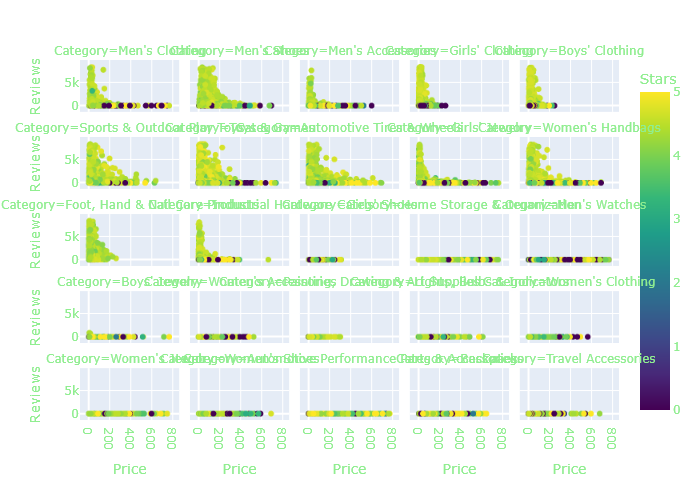

C:\Users\Bhavana\AppData\Local\Temp\ipykernel_25416\2863357056.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bhavana\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



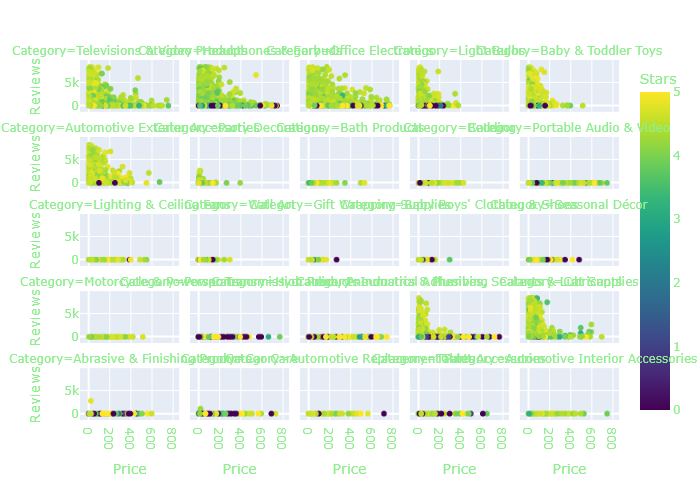

C:\Users\Bhavana\AppData\Local\Temp\ipykernel_25416\2863357056.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bhavana\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



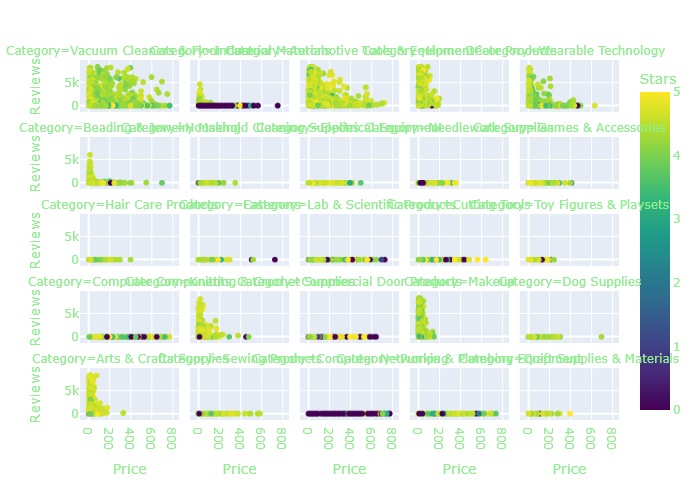

C:\Users\Bhavana\AppData\Local\Temp\ipykernel_25416\2863357056.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bhavana\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



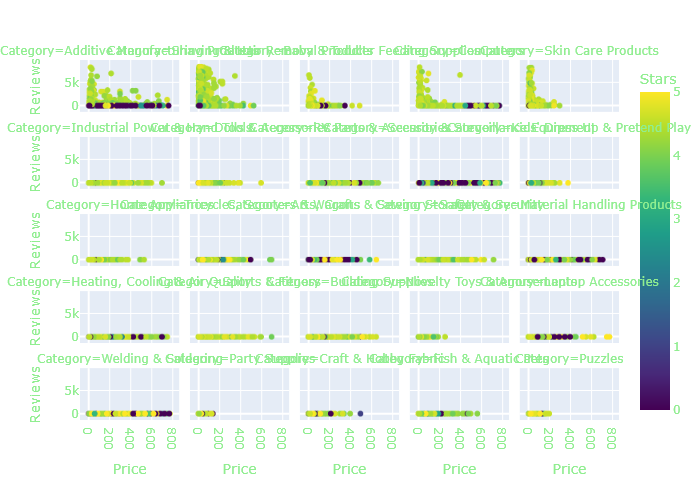

C:\Users\Bhavana\AppData\Local\Temp\ipykernel_25416\2863357056.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bhavana\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



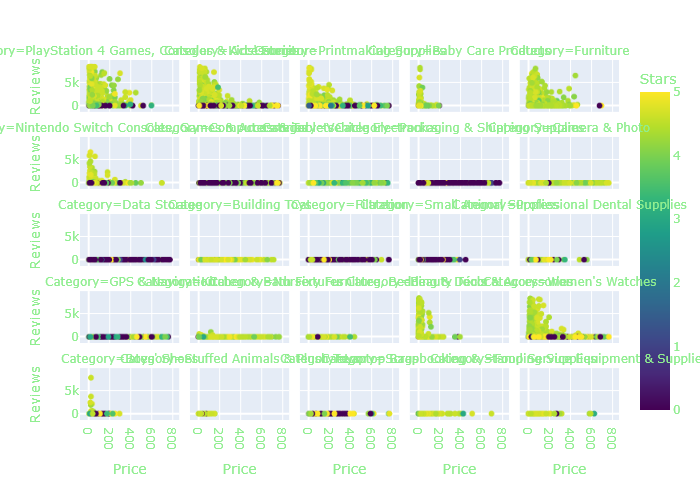

C:\Users\Bhavana\AppData\Local\Temp\ipykernel_25416\2863357056.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bhavana\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



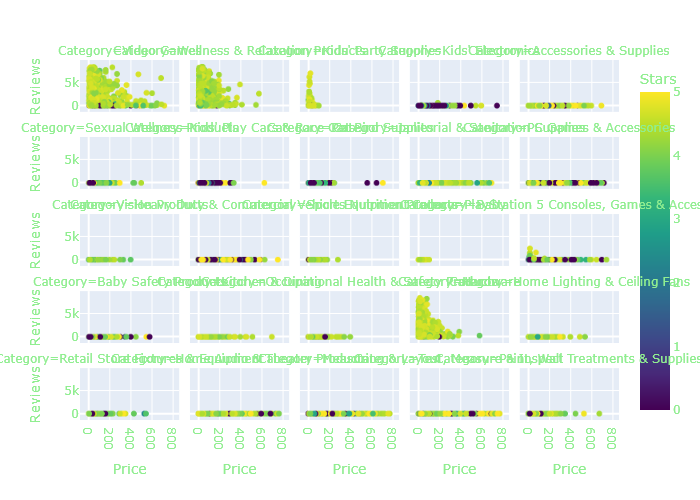

C:\Users\Bhavana\AppData\Local\Temp\ipykernel_25416\2863357056.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bhavana\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



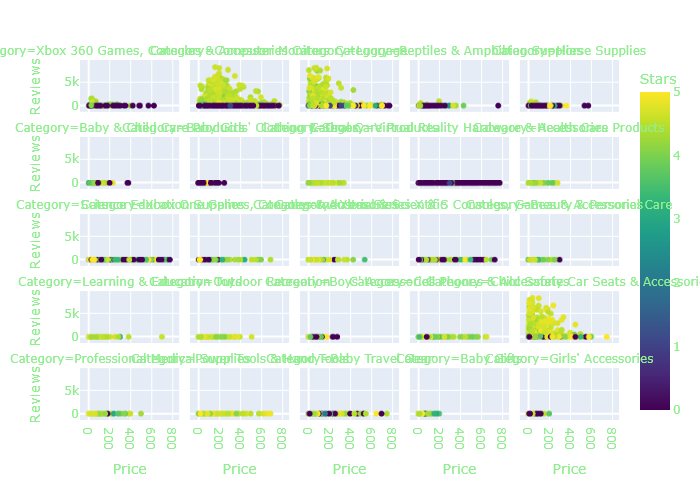

C:\Users\Bhavana\AppData\Local\Temp\ipykernel_25416\2863357056.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bhavana\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



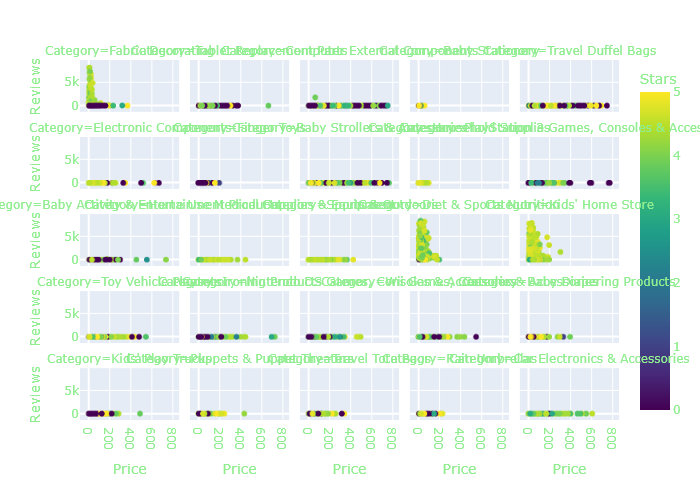

C:\Users\Bhavana\AppData\Local\Temp\ipykernel_25416\2863357056.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bhavana\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



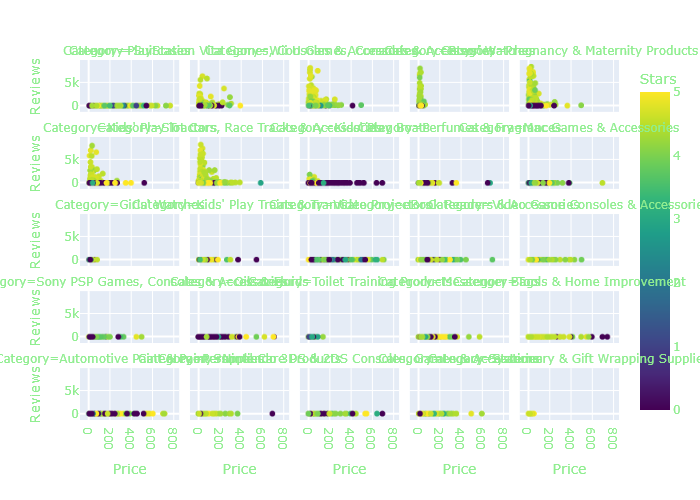

C:\Users\Bhavana\AppData\Local\Temp\ipykernel_25416\2863357056.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bhavana\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



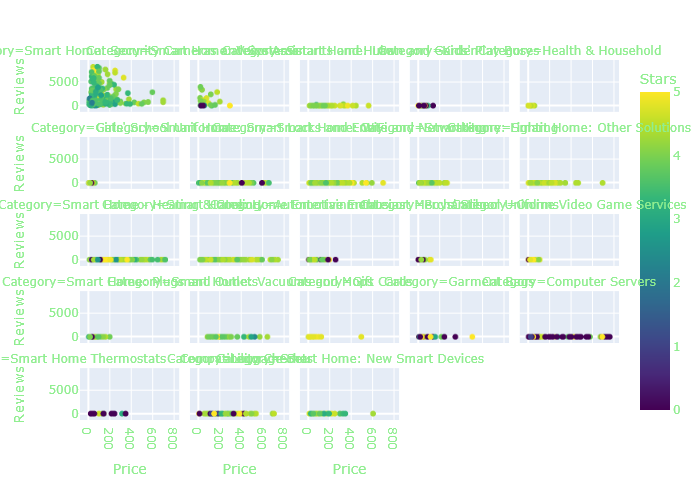

In [61]:

for i in range(0, 248, 25):
    if i == 225:
        df = df_az[df_az["Category"].isin(list(df_az["Category"].value_counts().index[i:]))]
    else:
        df = df_az[df_az["Category"].isin(list(df_az["Category"].value_counts().index[i:(i+25)]))]
    df["Category"] = df["Category"].cat.remove_unused_categories()
    fig = px.scatter(df, "Price", "Reviews", color="Stars", facet_col="Category", facet_col_wrap=5)
    fig.show(renderer="png")

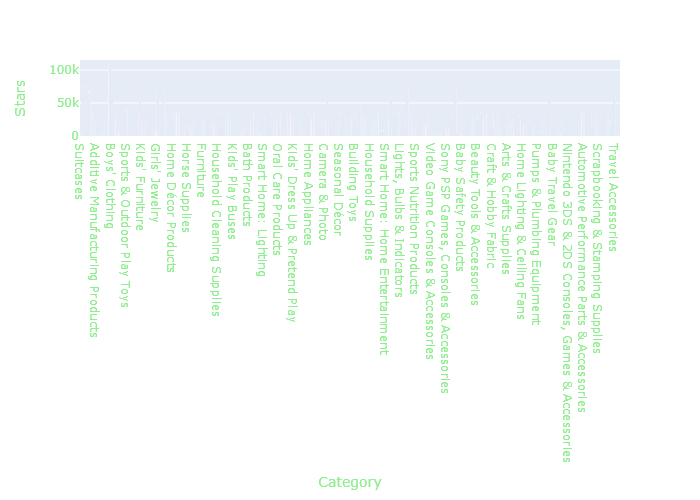

In [63]:
fig = px.bar(df_az, x="Category", y="Stars")
fig.show(renderer="png")

In [56]:
df_az["Category"].isin()

TypeError: Series.isin() missing 1 required positional argument: 'values'